In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
# Define a simple convolutional autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # to ensure outputs are in [0,1]
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# Training settings
latent_dim = 64
num_epochs = 10
batch_size = 128
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data: using MNIST for demonstration
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed, latent = model(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Step 2: Extract latent representations and perform clustering.

In [11]:
# Extract latent representations from the trained model
model.eval()
latents = []
labels_true = []  # for evaluation or visualization (if labels are available)
with torch.no_grad():
    for data, targets in train_loader:
        data = data.to(device)
        _, mu, logvar = model(data)
        latents.append(latent.cpu().numpy())
        labels_true.append(targets.numpy())

latents = np.concatenate(latents, axis=0)
labels_true = np.concatenate(labels_true, axis=0)

ValueError: too many values to unpack (expected 2)

In [ ]:
# Perform clustering using KMeans (here, n_clusters is set to 10 for MNIST)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latents)

# Reduce dimensions for visualization (using PCA)
pca = PCA(n_components=10)
latents_2d = pca.fit_transform(latents)

# Clustering on PCA-reduced latent representations
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(latents_2d)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("KMeans Clustering on Latent Representations (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels_true, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("True Labels on Latent Representations (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=cluster_labels_pca, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("KMeans Clustering on Latent Representations (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(train_dataset[500][0].squeeze(), cmap='gray')

2. **Alternative Techniques for Latent Extraction**

    **Variational Autoencoders (VAEs)**:
    VAEs learn a probabilistic latent space that can sometimes yield smoother clusters. The latent space is regularized to follow a known distribution (often Gaussian), which can be beneficial for clustering tasks.

    **Contrastive Learning (e.g., SimCLR, MoCo)**:
    These self-supervised methods learn representations by maximizing agreement between augmented views of the same image. The resulting embeddings often capture semantic similarities and can be clustered effectively.

    **Pre-trained CNN Features**:
    Instead of training an autoencoder from scratch, you could use features from a pre-trained network (like ResNet or EfficientNet). For example, extract features from the penultimate layer and then apply dimensionality reduction (PCA/UMAP) followed by clustering.

In [72]:
# Variational Autoencoder (VAE)
import torch.distributions as dist

class VAE(nn.Module):
    def __init__(self, latent_dim=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*4*4, 16*4*4),
            nn.ReLU(),
            nn.Linear(16*4*4, latent_dim*2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 4*4),
            nn.ReLU(),
            nn.Linear(16 * 4*4, 32 * 7 *7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # to ensure outputs are in [0,1]
        )

    def reparameterize(self, mu, logvar):
        # n = dist.Normal(mu, torch.exp(0.5 * logvar))
        # return n.rsample()
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar, z = self.encode(x)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    
    def encode(self, x):
        latent = self.encoder(x)
        mu, logvar = latent.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return mu, logvar, z
    
    def decode(self, z):
        return self.decoder(z)


![text](https://wikimedia.org/api/rest_v1/media/math/render/svg/73089eea69fb78640f804f2a5f07b963a021ef79)

In [76]:
# Training settings
latent_dim = 128
num_epochs = 30
batch_size = 128
learning_rate = 1e-4
kld_weight = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=latent_dim).to(device)
criterion_reconstruction = nn.BCELoss(reduction='mean')
def kl_regularizer(mu, logvar, kl_weight=1.0):
    """ KL Divergence regularizer """
    # it still returns a vector with dim: (batchsize,)
    return kl_weight * 2 * torch.sum(torch.exp(logvar) + mu ** 2 - 1 - logvar, 1)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(data)
        loss_reconstruction = criterion_reconstruction(reconstructed, data)
        loss_kld = kl_regularizer(mu, logvar, kld_weight).mean()
        loss = loss_reconstruction + loss_kld
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Reconstruction Loss: {loss_reconstruction:.4f}, KL Divergence Loss: {loss_kld:.4f}")

Epoch [1/30], Loss: 0.3929, Reconstruction Loss: 0.2702, KL Divergence Loss: 0.0000
Epoch [2/30], Loss: 0.2676, Reconstruction Loss: 0.2688, KL Divergence Loss: 0.0000
Epoch [3/30], Loss: 0.2648, Reconstruction Loss: 0.2729, KL Divergence Loss: 0.0000
Epoch [4/30], Loss: 0.2640, Reconstruction Loss: 0.2649, KL Divergence Loss: 0.0000
Epoch [5/30], Loss: 0.2637, Reconstruction Loss: 0.2662, KL Divergence Loss: 0.0000
Epoch [6/30], Loss: 0.2636, Reconstruction Loss: 0.2549, KL Divergence Loss: 0.0000
Epoch [7/30], Loss: 0.2635, Reconstruction Loss: 0.2687, KL Divergence Loss: 0.0000
Epoch [8/30], Loss: 0.2634, Reconstruction Loss: 0.2698, KL Divergence Loss: 0.0000
Epoch [9/30], Loss: 0.2634, Reconstruction Loss: 0.2561, KL Divergence Loss: 0.0000
Epoch [10/30], Loss: 0.2633, Reconstruction Loss: 0.2719, KL Divergence Loss: 0.0000
Epoch [11/30], Loss: 0.2633, Reconstruction Loss: 0.2602, KL Divergence Loss: 0.0000
Epoch [12/30], Loss: 0.2633, Reconstruction Loss: 0.2683, KL Divergence Lo

In [49]:
# Extract latent representations from the trained model
model.eval()
latents = []
labels_true = []  # for evaluation or visualization (if labels are available)
with torch.no_grad():
    for data, targets in train_loader:
        data = data.to(device)
        reconstructed, mu, logvar = model(data)
        latent = model.reparameterize(mu, logvar)
        latents.append(latent.cpu().numpy())
        labels_true.append(targets.numpy())

latents = np.concatenate(latents, axis=0)
labels_true = np.concatenate(labels_true, axis=0)

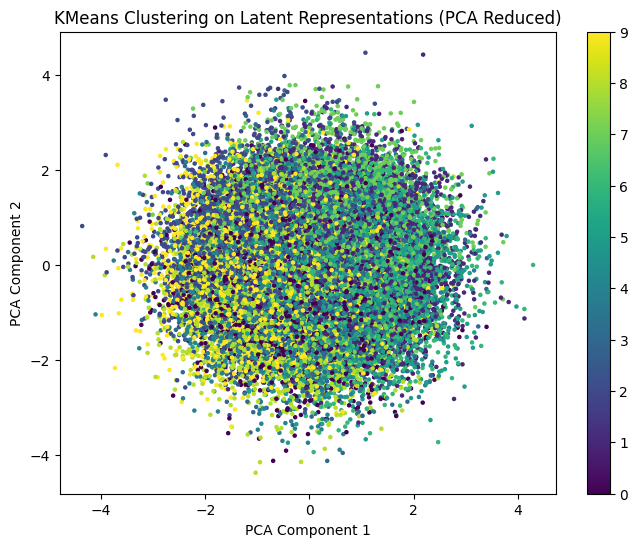

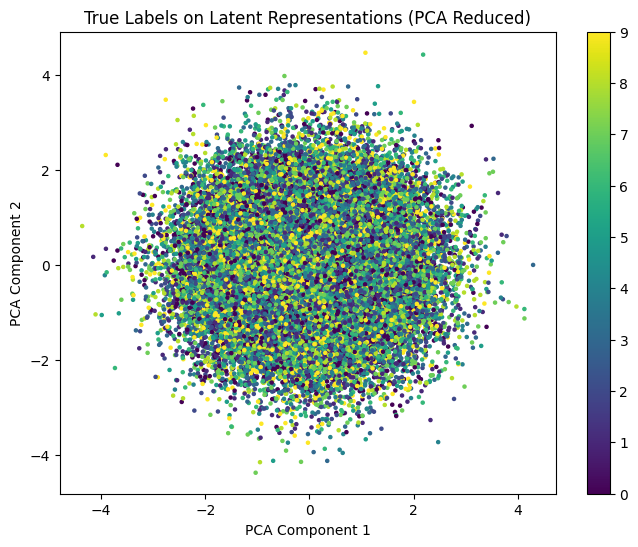

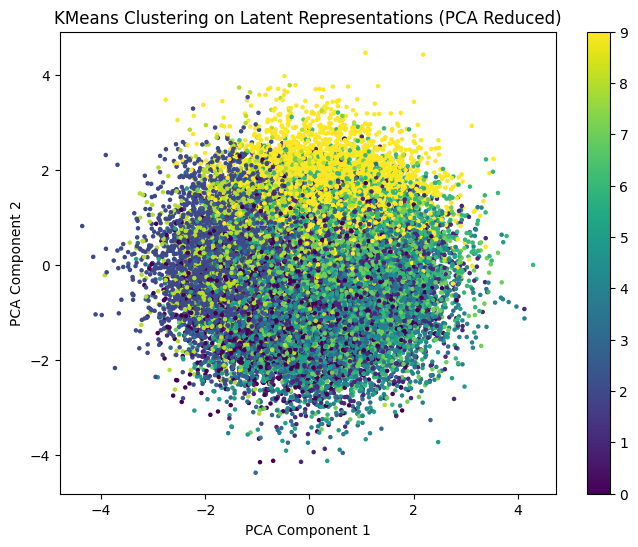

In [50]:
# Perform clustering using KMeans (here, n_clusters is set to 10 for MNIST)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latents)

# Reduce dimensions for visualization (using PCA)
pca = PCA(n_components=10)
latents_2d = pca.fit_transform(latents)

# Clustering on PCA-reduced latent representations
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(latents_2d)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("KMeans Clustering on Latent Representations (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels_true, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("True Labels on Latent Representations (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=cluster_labels_pca, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("KMeans Clustering on Latent Representations (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Generate a random image from the latent space and decode it to check the quality of the latent space.

tensor([[ 2.1330e-01, -1.4778e-01,  6.0794e-01, -9.4323e-01, -8.1888e-01,
          1.1955e-01, -7.3698e-02, -2.0537e-01, -3.4739e-01, -8.6236e-01,
          2.2838e+00,  6.5820e-01,  7.8795e-01,  6.6951e-01, -5.8466e-01,
          3.9331e-02, -1.5448e+00, -1.5375e-01, -1.2742e+00, -3.6896e-01,
          9.1824e-01,  4.7850e-01, -1.0456e-01,  1.0023e+00, -1.1110e+00,
          1.6794e-01,  5.2308e-01,  5.2381e-02, -7.5491e-01,  3.9528e-01,
          1.5410e-01, -3.2464e-01, -1.6012e+00, -1.3265e+00,  6.9962e-02,
         -1.3267e+00, -1.0585e+00, -5.1639e-01, -5.9426e-01,  1.1927e+00,
          1.1250e+00, -2.8529e-01, -3.4256e-01,  7.0546e-01, -2.1557e-01,
          1.0765e+00, -2.7885e-01, -1.7501e-03,  4.4631e-01,  4.9843e-01,
         -1.6030e+00, -7.8754e-01,  8.2668e-01,  6.2408e-02,  4.4271e-01,
         -7.4848e-01, -5.7295e-01,  4.5485e-01,  1.4788e+00, -1.3219e-01,
          2.0385e-01,  1.3600e+00, -1.8045e-01,  1.5148e+00,  1.0232e+00,
         -8.0495e-02,  8.3993e-01,  6.

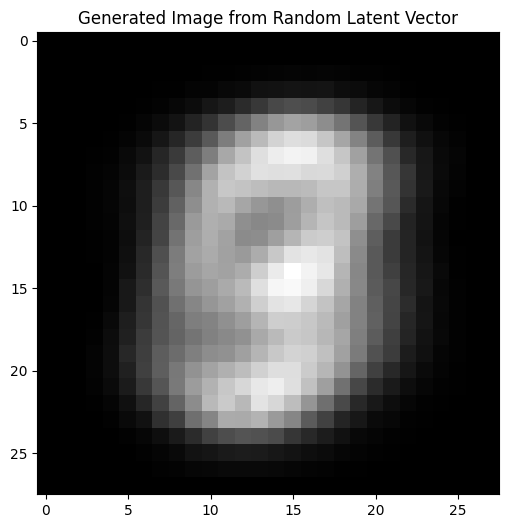

In [75]:
rnd_vector = torch.randn(1, latent_dim, device=device)
print(rnd_vector)
model.eval()
with torch.no_grad():
    generated = model.decode(rnd_vector).squeeze().cpu().numpy()

plt.figure(figsize=(8, 6))
plt.imshow(generated, cmap='gray')
plt.title("Generated Image from Random Latent Vector")
plt.show()

3. Alternative Clustering Techniques

    **DBSCAN / HDBSCAN**:
    These density-based clustering algorithms do not require specifying the number of clusters in advance and can handle clusters of arbitrary shapes. They can be particularly useful if your latent space has complex structures.

    **Agglomerative Clustering**:
    A hierarchical method that can be used to understand the nested structure of your data.

**Example with DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN

# DBSCAN clustering on latent representations
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(latents)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=dbscan_labels, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("DBSCAN Clustering on Latent Representations (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

4. Additional Pre-processing and ML Techniques

- **Data Normalization & Standardization**:
    Ensure that images are normalized (e.g., scaling pixel values to [0, 1] or standardizing them) before training, especially when combining features from different modalities.

- **Data Augmentation**:
    Apply techniques such as rotation, flipping, brightness/contrast adjustments, or even more advanced methods like GAN-based synthetic augmentation to increase the robustness of your model.

- **Dimensionality Reduction**:
    Use PCA, t-SNE, or UMAP not only for visualization but also as a pre-processing step to remove noise and reduce complexity before clustering.

- **Outlier Detection**:
    Techniques like Isolation Forest or One-Class SVM can help remove or flag anomalous images, which is particularly useful in quality control applications.

- **Deep Clustering Methods:**
    Algorithms like Deep Embedded Clustering (DEC) or its variants integrate representation learning and clustering in a joint optimization framework, potentially leading to better performance on complex data.